# Hands-on Physical Reservoir Computing

Table of contents
1. Preparation
    - [Load the dataset](#loadthe)
2. Reservoir computing
    - [Set up the reservoir](#set-up-the-reservoir)
    - [Collect reservoir states](#collect-reservoir-states)
    - [Evaluate performance](#evaluate-the-performance)
5. Optimize the reservoir
    - [Readout training](#optimizing-the-reservoir-readout-training)
    - [Reservoir tuning](#optimizing-the-reservoir-reservoir-tuning): [timescale](#timescales-leak-rate), [dynamical regime](#dynamical-regime-spectral-radius), [capacity](#capacity-number-of-neurons)
6. Final performance
    - [Optimize readout](#optimize-readout-training)
    - [Evaluate on testing data](#evaluate-performance-on-unseen-testing-data)

<!-- <a class="anchor" id="load-dataset"></a> -->

In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

In [2]:
random.seed(7)
np.random.seed(7)

## Load the dataset

We are loading the [Iris](https://www.kaggle.com/datasets/uciml/iris) flower classification dataset (downloaded from [Kaggle](https://www.kaggle.com/), see `iris.csv` in this directory). This is one of the best-known pattern recognition tasks. It is a simple task, but the classes are not linearly separable. 

We use the `pd.get_dummies` function to turn the categorical target variable (the species of the flower) into a one-hot encoded numerical vector. We then convert the dataset into a numpy array.

In [3]:
df = pd.read_csv('iris.csv', index_col=0)
df = pd.get_dummies(df)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species_Iris-setosa,Species_Iris-versicolor,Species_Iris-virginica
Id,,,,,,,
1,5.1,3.5,1.4,0.2,1,0,0
2,4.9,3.0,1.4,0.2,1,0,0
3,4.7,3.2,1.3,0.2,1,0,0
4,4.6,3.1,1.5,0.2,1,0,0
5,5.0,3.6,1.4,0.2,1,0,0


In [4]:
data_raw = df.to_numpy()
data_raw.shape

(150, 7)

The numpy array has 150 data points, each with 7 values (the first 4 are inputs, the other 3 are outputs of our classification task). Before we do any further processing, we randomly split the dataset into training and testing data. We split the data evenly with respect to the classes, such that the number of samples of each class in the training and testing data are equal. 

In [5]:
sample = lambda a, b: random.sample(range(a, b), 40)
train_idxs = sample(0, 50) + sample(50, 100) + sample(100, 150)
test_idxs = [idx for idx in range(150) if idx not in train_idxs]

We then pre-process the data by diving each of the four features by its respective maximum value in the training data. 

In [6]:
# standardize data: divide each feature by maximum value (computed on training data only)
data = data_raw.copy()
data[:,:4] = data[:,:4] / data[train_idxs,:4].max(axis=0)

Reservoir computing works with temporal signals, but we currently do not have any time series data. Instead, each sample is a four dimensional vector $u \in \mathbb{R}^4$. We can turn each sample into a temporal signal by encoding the values into the frequencies of the sine function: $u_i \mapsto \sin(2\pi u_i t) \text{ for } i \in \{1,\ldots,4\}$. We then sample the sine function at fixed intervals to yield 500 samples. 

In [7]:
timesteps = np.arange(0, 50, 0.1)
u = np.array([
    np.vstack([np.sin(timesteps*2*np.pi*pt[i]) for i in range(4)]).T
    for pt in data[:,:4]
])
y = np.array([data[:,4:]] * len(timesteps)).swapaxes(0, 1)

Now, our dataset contains 150 samples, each of which is a time series with 500 discrete time steps. This makes the inputs `u` and the outputs `y` 3-dimensional data arrays (or tensors):

In [8]:
u.shape, y.shape

((150, 500, 4), (150, 500, 3))

Below we plot some input time series:

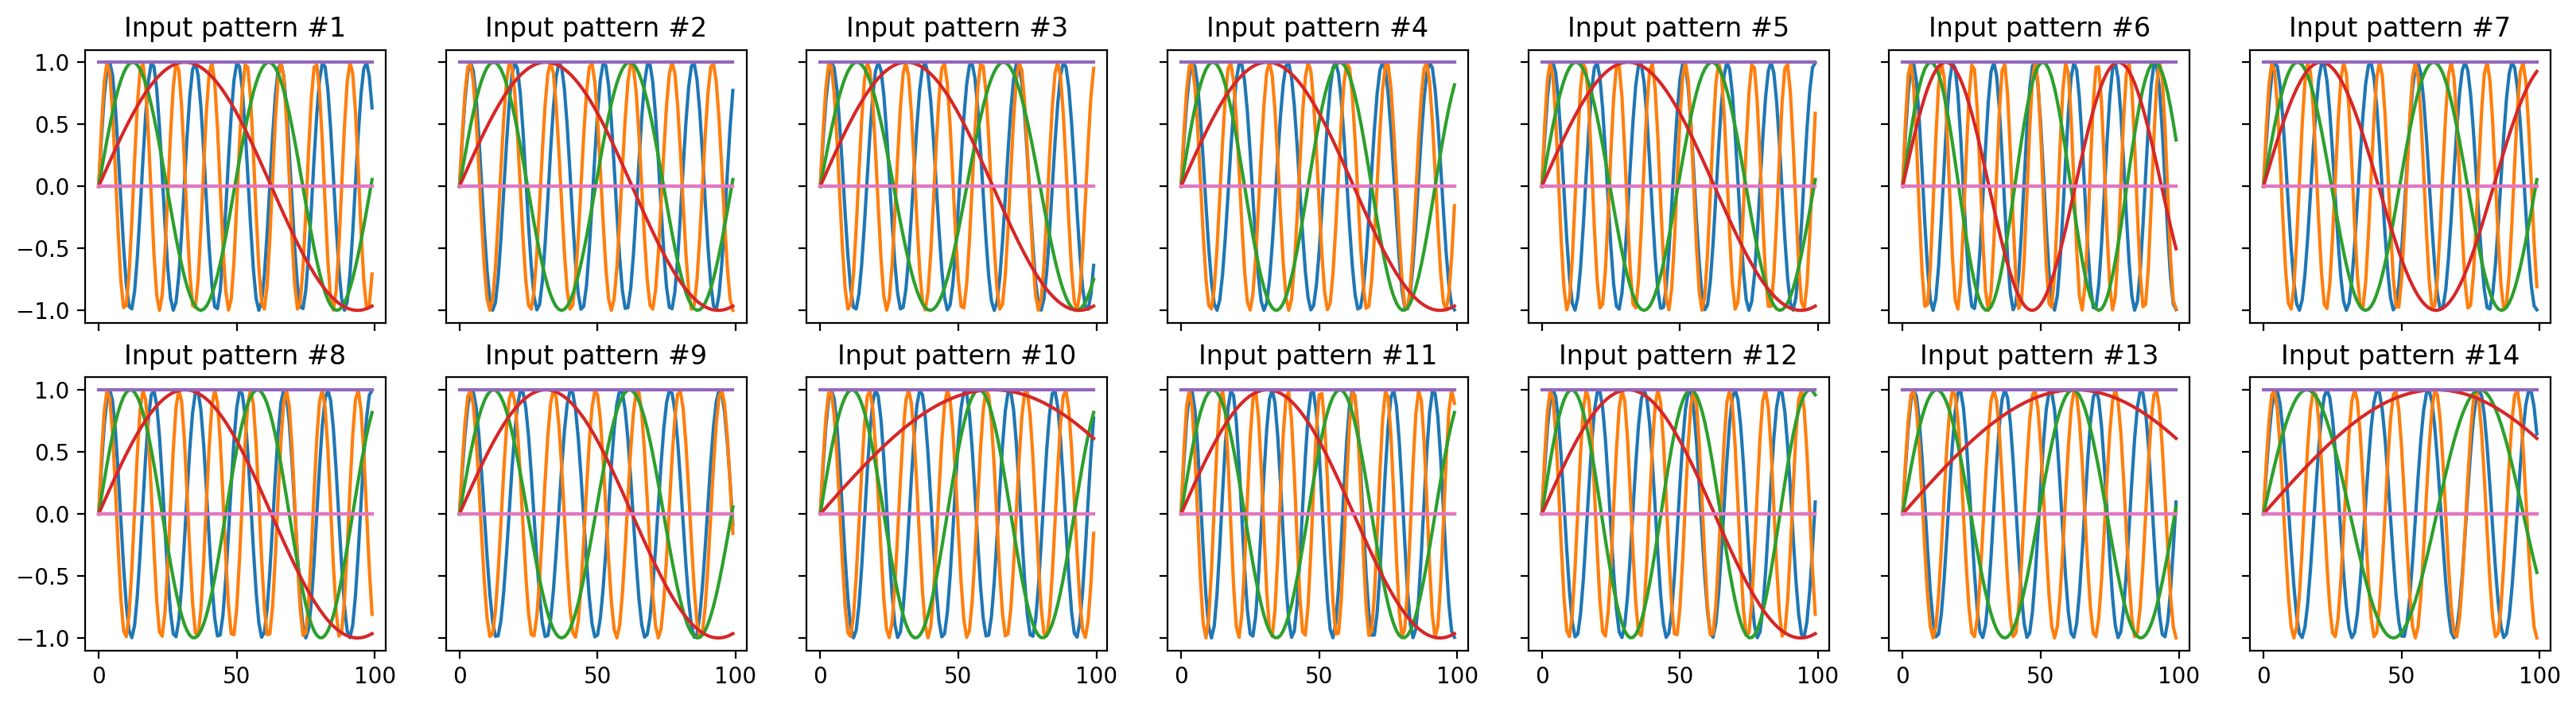

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=7, sharex=True, sharey=True, figsize=(20, 5), dpi=200)
for i in range(2):
    for j in range(7):
        axs[i][j].set_title(f'Input pattern #{i*7+j+1}')
        axs[i][j].plot(u[i*7+j,:100])
        axs[i][j].plot(y[i*7+j,:100])

Finally, we split the temporal signals into the training and testing datasets:

In [10]:
u_train = u[train_idxs]
y_train = y[train_idxs]
u_test = u[test_idxs]
y_test = y[test_idxs]

## Set up the reservoir

Now that the input signal is prepared, we will feed this signal to the reservoir. In physical reservoir computing, this reservoir is a physical system, but for this demonstration we will be modeling the reservoir in simulation with an Echo State Network, see the `reservoir.py` file for implementation details. 

In [11]:
from reservoir import Reservoir

In simulation, we can easily create a new reservoir with a set of parameters:

- `n_neurons`: number of neurons in the reservoir, corresponds to the dimension of the reservoir, or its computational capacity/power
- `rhow`: the spectral radius of the reservoir, corresponds to the dynamical regime of the reservoir. When the input signal is ommitted, for small values, activity in the reservoir will die out quickly while for large values, activity in the reservoir will tend to explode (see the paper for details).
- `leak_range`: leak rate of the reservoir's update equations. This tunes the *timescale* of the reservoir. A lower leak rate will lead to a slower reservoir. In this implementation, the leak rate is specified by two parameters, the minimum $a$ and maximum $b$ leak rate, and the actual leak rate of each neuron is sampled from the uniform distribution $\mathcal{U}(a,b)$.

In a physical setup, these parameters cannot be chosen as easily as in simulation. However, physical reservoirs often can be tuned in ways that correspond to one of the three parameters explained above. Therefore, we have chosen to set up the simulation as it is. We will first use standard values for the reservoir and see how it performs. Afterwards, we will tune the reservoir to improve the performance on our classification task.

In [12]:
reservoir = Reservoir(n_inputs=u_train.shape[2], n_neurons=20, rhow=1.25, leak_range=(0.1, 0.3))

## Collect reservoir states

Now that the reservoir has been created, we feed the input signal into the reservoir. To do this, we simply concatenate all input sequences and feed them into the reservoir. We can do this because we will discard the initial transient of each time series anyway (the so-called washout period, see below).

In [13]:
print(f'{u_train.shape} -> {np.concatenate(u_train).shape}')

(120, 500, 4) -> (60000, 4)


We then pass the training input signal to the reservoir and collect the states:

In [14]:
X_train = reservoir.forward(np.concatenate(u_train), collect_states=True)
X_train.shape

(60000, 20)

## Train the readout map

Now that we have the collected state matrix $X_{train}$ (`X_train`), we can use the training labels $Y_{train}$ (`y_train`) compute the readout map $\hat W^{out}$ which maps the reservoir state to the output vector. We do this using ridge regression:
$$
\hat W^{out} = (R + \alpha I)^{-1} P
$$
where $R=X_{train}^T X_{train}$ is the state correlation matrix, $P=X_{train}^T Y_{train}$ is the state-output cross-correlation matrix and $\alpha$ is the regularization parameter.

Note that we will "wash out" the initial time steps of each time series to ignore effects to due initial conditions of the reservoir. 

In [15]:
alpha = 1e-3
T_washout = 100

# drop states during the initial washout period of each time series
X_washout = X_train.reshape((u_train.shape[0], u_train.shape[1], -1))[:, T_washout:, :]
X = np.concatenate(X_washout)
Y = np.concatenate(y_train[:, T_washout:, :])
# state correlation matrix
R = X.T @ X
# state-output cross-correlation matrix
P = X.T @ Y
# ridge regression: state -> output
wout = np.linalg.inv((R + alpha * np.eye(X_train.shape[1]))) @ P

## Evaluate the performance

Now that we computed the readout map, we can apply it to the reservoir states that we collected for the training data, in order to evaluate the accuracy of our reservoir classifier. 

In [16]:
y_pred_train = X_train @ wout

We can evaluate the accuracy in multiple ways. In the simplest approach, we can take the class that the reservoir predicts for every single time step and compare that to the ground truth from our dataset.

In [17]:
def accuracy_elementwise(ypred, ytrue):
    # compute accuracy at each time step
    yp = ypred.reshape(-1, ytrue.shape[2]).argmax(axis=1)
    yt = ytrue.reshape(-1, ytrue.shape[2]).argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]

In [18]:
print(f'Training accuracy: {accuracy_elementwise(y_pred_train, y_train):.2%} (per time step)')

Training accuracy: 52.33% (per time step)


But since we want to classify the entire time series as a whole, and not each individual time step, we can also average the output of the reservoir for each time series and use the average as the class predicted by the reservoir for this time series. We would expect this to perform much better. 

In [19]:
def accuracy(ypred, ytrue):
    # compute accuracy by averaging the predicted class over the whole time series
    yp = ypred.reshape(ytrue.shape).mean(axis=1).argmax(axis=1)
    yt = ytrue[:,0,:].argmax(axis=1)
    return np.sum(yp == yt) / yp.shape[0]

In [20]:
print(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)')

Training accuracy: 77.50% (per time series)


We have evaluated the training accuracy now, but we also need to evaluate the performance of the reservoir on unseen examples. To do this, we feed the testing input to the reservoir, collect the reservoir states into the matrix $X_{test}$ and apply the readout matrix $\hat W^{out}$ to this matrix in order to get the predicted output on the testing data:

In [21]:
X_test = reservoir.forward(np.concatenate(u_test), collect_states=True)
y_pred_test = X_test @ wout

And we report both accuracy metrics for the testing data:

In [22]:
print(f'Testing accuracy:  {accuracy_elementwise(y_pred_test, y_test):.2%} (per time step)')
print(f'Testing accuracy:  {accuracy(y_pred_test, y_test):.2%} (per time series)')

Testing accuracy:  51.59% (per time step)
Testing accuracy:  70.00% (per time series)


In summary, this is how our reservoir performed on the classification task:

In [23]:
print(f'Training accuracy: {accuracy(y_pred_train, y_train):.2%} (per time series)')
print(f'Testing accuracy:  {accuracy(y_pred_test, y_test):.2%} (per time series)')

Training accuracy: 77.50% (per time series)
Testing accuracy:  70.00% (per time series)


```
Training accuracy: 77.50% (per time series)
Testing accuracy:  70.00% (per time series)
```

## Optimizing the reservoir: readout training

The resulting performance above (70% testing accuracy) is not good. We would expect to solve the Iris classification task with >90% testing accuracy. Since we are working with physical reservoirs, optimizing the reservoir can be quite expensive in terms of time and other resources. We therefore begin by optimizing the readout training procedure, which is anyway done on a digital computer. To make this easy, we abstract the training into function and then run a sweep over different learning parameters (here, we just tune the washout length and the regularization parameter $\alpha$) and compare the results. As described in the paper, we need to do this in a validation loop because we cannot optimize our parameters based on the testing performance.

In [24]:
def compute_wout(X, Y, T_washout=0, alpha=1e-3):
    n_samples, n_timesteps, _ = Y.shape
    X = X.reshape((n_samples, n_timesteps, -1))[:, T_washout:, :]
    X = np.concatenate(X)
    Y = np.concatenate(Y[:, T_washout:, :])
    R = X.T @ X
    P = X.T @ Y
    return np.linalg.inv(R + alpha * np.eye(X.shape[1])) @ P

We proceed by making a list of all parameter configurations that we want to test:

In [25]:
list_alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1., 10., 100.]
list_T_washout = [0, 10, 50, 100, 200]

All other parameters are kept fixed:

In [26]:
n_neurons = 20
rhow = 1.25
leak_range = (0.1, 0.3)

We iterate over all possible combinations of our parameter configurations with a Cartesian product (`itertools.product`). For each parameter configuration, we do cross-validation - we divide the training data into $n$ blocks and do $n$ iterations (or *folds*) of training where we alternate which block is used for validation (i.e. evaluation) and the remaining blocks are used for training. We store the training and validation accuracy for each fold for each parameter configuration.

In [27]:
results = {}
for alpha, T_washout in itertools.product(list_alpha, list_T_washout):
    # shuffle, then split u_train and y_train into five blocks
    n_folds = 5
    shuffled_idxs = random.sample(range(u_train.shape[0]), u_train.shape[0])
    u_train_split = np.array(np.array_split(u_train[shuffled_idxs], n_folds))
    y_train_split = np.array(np.array_split(y_train[shuffled_idxs], n_folds))

    # n-fold cross-validation
    train_accs, val_accs = [], []
    for val_idx in range(n_folds):
        # split training and validation
        trn_idxs = [e for e in range(n_folds) if e != val_idx]
        u_trn = np.concatenate(u_train_split[trn_idxs])
        u_val = u_train_split[val_idx]
        y_trn = np.concatenate(y_train_split[trn_idxs])
        y_val = y_train_split[val_idx]

        # configure reservoir
        reservoir = Reservoir(n_inputs=u_trn.shape[2], n_neurons=n_neurons, rhow=rhow, leak_range=leak_range)
        # train reservoir
        X_trn = reservoir.forward(np.concatenate(u_trn), collect_states=True)
        wout = compute_wout(X_trn, y_trn, T_washout=T_washout, alpha=alpha)
        # evaluate reservoir
        y_pred_trn = X_trn @ wout
        X_val = reservoir.forward(np.concatenate(u_val), collect_states=True)
        y_pred_val = X_val @ wout

        # store performance measures
        train_accs.append(accuracy(y_pred_trn, y_trn))
        val_accs.append(accuracy(y_pred_val, y_val))
    
    results[(alpha, T_washout)] = [train_accs, val_accs]

We can now evaluate the parameter configurations of our readout training procedure. We can display the validation accuracy (averaged over folds) as a table where the rows correspond to the washout period and the columns correspond to the regularization $\alpha$: 

In [28]:
val_accs = pd.DataFrame({
    alpha : {
        T_washout : np.array(results[(alpha, T_washout)][1]).mean()
        for T_washout in list_T_washout
    } for alpha in list_alpha
})
val_accs

,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000,100.0000
0,0.783333,0.691667,0.750000,0.758333,0.800000,0.658333,0.700000
10,0.825000,0.816667,0.725000,0.766667,0.825000,0.625000,0.733333
50,0.741667,0.708333,0.758333,0.675000,0.683333,0.708333,0.641667
100,0.733333,0.683333,0.616667,0.725000,0.733333,0.716667,0.733333
200,0.791667,0.725000,0.641667,0.833333,0.725000,0.666667,0.708333


We can see that the best parameter configuration is `T_washout=10` and `alpha=1e-3` or `alpha=1.0`, yielding a validation accuracy of `82.5%`. 

We can also take a look at the training accuracies:

In [29]:
train_accs = pd.DataFrame({
    alpha : {
        T_washout : np.array(results[(alpha, T_washout)][0]).mean()
        for T_washout in list_T_washout
    } for alpha in list_alpha
}, )
train_accs

,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000,100.0000
0,0.795833,0.754167,0.795833,0.810417,0.791667,0.779167,0.787500
10,0.837500,0.843750,0.787500,0.825000,0.847917,0.747917,0.793750
50,0.793750,0.768750,0.772917,0.795833,0.779167,0.775000,0.750000
100,0.772917,0.775000,0.764583,0.797917,0.783333,0.779167,0.779167
200,0.858333,0.833333,0.770833,0.827083,0.770833,0.731250,0.787500


To isolate the effect of the regularization $\alpha$ we can also look at the mean validation accuracy (averaged over all washout periods used):

In [30]:
val_accs.mean()

0.0001      0.775000
0.0010      0.725000
0.0100      0.698333
0.1000      0.751667
1.0000      0.753333
10.0000     0.675000
100.0000    0.703333
dtype: float64

And we can see that a small $\alpha=0.0001$ or the larger $\alpha=0.1$ and $\alpha=1.0$ yield the best performance. Similarly we can analyze the effect of the washout period:

In [31]:
val_accs.mean(axis=1)

0      0.734524
10     0.759524
50     0.702381
100    0.705952
200    0.727381
dtype: float64

And we can see that a shorter washout period of `T=10` may be ideal. 

### Final comments

We would expect the ideal value of $\alpha$ to change with different reservoirs sizes (e.g. a larger reservoir may require more regularization to prevent it from overfitting). Similarly, we would expect the ideal value for the washout period to change with reservoirs of varying timescales (e.g. a reservoir with a larger leak will be slower and would require a longer time to wash out its initial conditions, therefore requiring a larger washout period). 

This means that we will likely have to optimize our readout procedure again when we change the reservoir. 

## Optimizing the reservoir: reservoir tuning

Since our goal here is to simulate the process of tuning a physical reservoir, we will restrict ourselves in the number of possible reservoir configurations we can test. In simulation studies, we could simply run an extensive search over a large set of possible reservoir configurations and then choose the best one according to our validation and training accuracies. We will not do this here. Instead, we will take each one of the three reservoir parameters (number of neurons, spectral radius, and leak rate) and run only a few different reservoirs. 

### Timescales: leak rate

We can begin by varying the leak rate of the reservoir, which determines the timescale of the reservoir's dynamics.

In [32]:
list_leak_range = [
    (a - 0.025, a + 0.025)
    for a in [0.1, 0.2, 0.3, 0.4]
]
list_leak_range

[(0.07500000000000001, 0.125),
 (0.17500000000000002, 0.225),
 (0.27499999999999997, 0.325),
 (0.375, 0.42500000000000004)]

In [33]:
alpha = 1e-3
T_washout = 10
n_neurons = 20
rhow = 1.25

In [34]:
results = {}
X_trns = {}
for leak_range in list_leak_range:
    # shuffle, then split u_train and y_train into five blocks
    n_folds = 5
    shuffled_idxs = random.sample(range(u_train.shape[0]), u_train.shape[0])
    u_train_split = np.array(np.array_split(u_train[shuffled_idxs], n_folds))
    y_train_split = np.array(np.array_split(y_train[shuffled_idxs], n_folds))

    # n-fold cross-validation
    train_accs, val_accs = [], []
    for val_idx in range(n_folds):
        # split training and validation
        trn_idxs = [e for e in range(n_folds) if e != val_idx]
        u_trn = np.concatenate(u_train_split[trn_idxs])
        u_val = u_train_split[val_idx]
        y_trn = np.concatenate(y_train_split[trn_idxs])
        y_val = y_train_split[val_idx]

        # configure reservoir
        reservoir = Reservoir(n_inputs=u_trn.shape[2], n_neurons=n_neurons, rhow=rhow, leak_range=leak_range)
        # train reservoir
        X_trn = reservoir.forward(np.concatenate(u_trn), collect_states=True)
        wout = compute_wout(X_trn, y_trn, T_washout=T_washout, alpha=alpha)
        # evaluate reservoir
        y_pred_trn = X_trn @ wout
        X_val = reservoir.forward(np.concatenate(u_val), collect_states=True)
        y_pred_val = X_val @ wout

        # store performance measures
        train_accs.append(accuracy(y_pred_trn, y_trn))
        val_accs.append(accuracy(y_pred_val, y_val))
        X_trns[leak_range[0]+0.025] = X_trn
    
    results[leak_range[0]+0.025] = [train_accs, val_accs]

In [35]:
for leak_range, res in results.items():
    print(f'leak ~{leak_range:0.1f}: {np.array(res[0]).mean():.2%} train {np.array(res[1]).mean():.2%} val ')

leak ~0.1: 79.17% train 69.17% val 
leak ~0.2: 82.50% train 75.00% val 
leak ~0.3: 82.50% train 80.00% val 
leak ~0.4: 69.58% train 65.00% val 


So it appears that a leak distribution centered around 0.3 is the best (out of the four configurations we tried). We can take a look at the readout time signals $X_{train}(t)$ that we collected from the reservoir: 

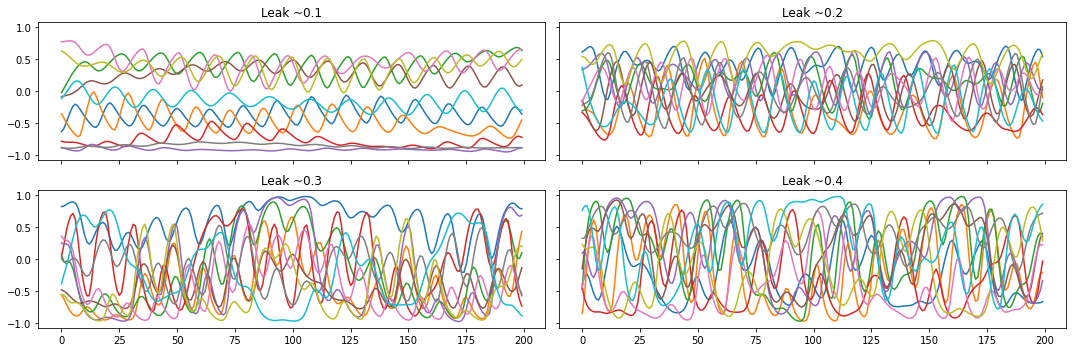

In [36]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(15,5))
for idx, (leak_range, X_trn) in enumerate(X_trns.items()):
    ax = axs[idx//2][idx%2]
    ax.set_title(f'Leak ~{leak_range:0.1f}')
    ax.plot(X_trn[1500:1700, 5:15])
fig.tight_layout()

It clearly shows that the readout signals from reservoirs with lower leak are slower whereas those with higher leak are faster and their plots look more crowded. 

### Dynamical regime: spectral radius

In [37]:
list_rhow = [
    0.75, 1.0, 1.25, 1.5, 2.0, 2.5
]
list_rhow

[0.75, 1.0, 1.25, 1.5, 2.0, 2.5]

In [38]:
alpha = 1e-3
leak_range = (0.275, 0.325)
T_washout = 10
n_neurons = 20

In [39]:
results = {}
X_trns = {}
for rhow in list_rhow:
    # shuffle, then split u_train and y_train into five blocks
    n_folds = 5
    shuffled_idxs = random.sample(range(u_train.shape[0]), u_train.shape[0])
    u_train_split = np.array(np.array_split(u_train[shuffled_idxs], n_folds))
    y_train_split = np.array(np.array_split(y_train[shuffled_idxs], n_folds))

    # n-fold cross-validation
    train_accs, val_accs = [], []
    for val_idx in range(n_folds):
        # split training and validation
        trn_idxs = [e for e in range(n_folds) if e != val_idx]
        u_trn = np.concatenate(u_train_split[trn_idxs])
        u_val = u_train_split[val_idx]
        y_trn = np.concatenate(y_train_split[trn_idxs])
        y_val = y_train_split[val_idx]

        # configure reservoir
        reservoir = Reservoir(n_inputs=u_trn.shape[2], n_neurons=n_neurons, rhow=rhow, leak_range=leak_range)
        # train reservoir
        X_trn = reservoir.forward(np.concatenate(u_trn), collect_states=True)
        wout = compute_wout(X_trn, y_trn, T_washout=T_washout, alpha=alpha)
        # evaluate reservoir
        y_pred_trn = X_trn @ wout
        X_val = reservoir.forward(np.concatenate(u_val), collect_states=True)
        y_pred_val = X_val @ wout

        # store performance measures
        train_accs.append(accuracy(y_pred_trn, y_trn))
        val_accs.append(accuracy(y_pred_val, y_val))
        X_trns[rhow] = X_trn
    
    results[rhow] = [train_accs, val_accs]

In [40]:
for rhow, res in results.items():
    print(f'rho_w {rhow:0.2f}: {np.array(res[0]).mean():.2%} train {np.array(res[1]).mean():.2%} val ')

rho_w 0.75: 69.58% train 59.17% val 
rho_w 1.00: 72.71% train 63.33% val 
rho_w 1.25: 75.00% train 65.00% val 
rho_w 1.50: 85.00% train 78.33% val 
rho_w 2.00: 78.12% train 70.83% val 
rho_w 2.50: 81.25% train 72.50% val 


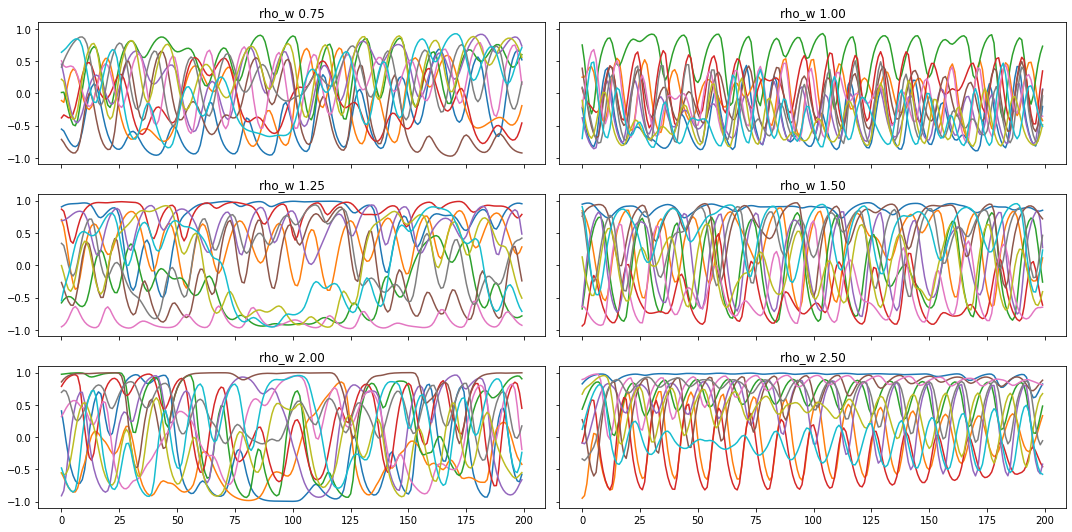

In [41]:
fig, axs = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True, figsize=(15,7.5))
for idx, (rhow, X_trn) in enumerate(X_trns.items()):
    ax = axs[idx//2][idx%2]
    ax.set_title(f'rho_w {rhow:0.2f}')
    ax.plot(X_trn[1500:1700, 5:15])
fig.tight_layout()

### Capacity: number of neurons

In [42]:
list_n_neurons = [
    10, 20, 50, 100
]
list_n_neurons

[10, 20, 50, 100]

In [43]:
alpha = 1e-3
leak_range = (0.275, 0.325)
rhow = 1.5
T_washout = 10

In [44]:
results = {}
X_trns = {}
for n_neurons in list_n_neurons:
    # shuffle, then split u_train and y_train into five blocks
    n_folds = 5
    shuffled_idxs = random.sample(range(u_train.shape[0]), u_train.shape[0])
    u_train_split = np.array(np.array_split(u_train[shuffled_idxs], n_folds))
    y_train_split = np.array(np.array_split(y_train[shuffled_idxs], n_folds))

    # n-fold cross-validation
    train_accs, val_accs = [], []
    for val_idx in range(n_folds):
        # split training and validation
        trn_idxs = [e for e in range(n_folds) if e != val_idx]
        u_trn = np.concatenate(u_train_split[trn_idxs])
        u_val = u_train_split[val_idx]
        y_trn = np.concatenate(y_train_split[trn_idxs])
        y_val = y_train_split[val_idx]

        # configure reservoir
        reservoir = Reservoir(n_inputs=u_trn.shape[2], n_neurons=n_neurons, rhow=rhow, leak_range=leak_range)
        # train reservoir
        X_trn = reservoir.forward(np.concatenate(u_trn), collect_states=True)
        wout = compute_wout(X_trn, y_trn, T_washout=T_washout, alpha=alpha)
        # evaluate reservoir
        y_pred_trn = X_trn @ wout
        X_val = reservoir.forward(np.concatenate(u_val), collect_states=True)
        y_pred_val = X_val @ wout

        # store performance measures
        train_accs.append(accuracy(y_pred_trn, y_trn))
        val_accs.append(accuracy(y_pred_val, y_val))
        X_trns[n_neurons] = X_trn
    
    results[n_neurons] = [train_accs, val_accs]

In [45]:
for n_neurons, res in results.items():
    print(f'{n_neurons:>3} neurons: {np.array(res[0]).mean():.2%} train {np.array(res[1]).mean():.2%} val ')

 10 neurons: 69.58% train 65.83% val 
 20 neurons: 78.33% train 70.00% val 
 50 neurons: 88.12% train 87.50% val 
100 neurons: 96.88% train 94.17% val 


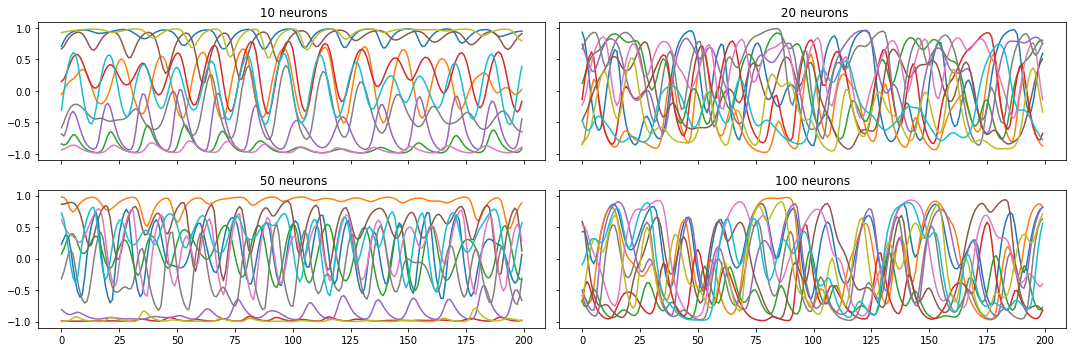

In [46]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(15,5))
for idx, (n_neurons, X_trn) in enumerate(X_trns.items()):
    ax = axs[idx//2][idx%2]
    ax.set_title(f'{n_neurons:>3} neurons')
    ax.plot(X_trn[1500:1700, :10])
fig.tight_layout()

As expected, the number of neurons increases the classification performance significantly.

## Final reservoir performance

### Optimize readout training

We now optimize the readout training procedure for the reservoir configuration which we have found to work best. 

In [47]:
list_alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1., 10., 100.]
list_T_washout = [0, 10, 50, 100, 200]

In [48]:
n_neurons = 100
rhow = 1.5
leak_range = (0.275, 0.325)

In [49]:
results = {}
for alpha, T_washout in itertools.product(list_alpha, list_T_washout):
    # shuffle, then split u_train and y_train into five blocks
    n_folds = 5
    shuffled_idxs = random.sample(range(u_train.shape[0]), u_train.shape[0])
    u_train_split = np.array(np.array_split(u_train[shuffled_idxs], n_folds))
    y_train_split = np.array(np.array_split(y_train[shuffled_idxs], n_folds))

    # n-fold cross-validation
    train_accs, val_accs = [], []
    for val_idx in range(n_folds):
        # split training and validation
        trn_idxs = [e for e in range(n_folds) if e != val_idx]
        u_trn = np.concatenate(u_train_split[trn_idxs])
        u_val = u_train_split[val_idx]
        y_trn = np.concatenate(y_train_split[trn_idxs])
        y_val = y_train_split[val_idx]

        # configure reservoir
        reservoir = Reservoir(n_inputs=u_trn.shape[2], n_neurons=n_neurons, rhow=rhow, leak_range=leak_range)
        # train reservoir
        X_trn = reservoir.forward(np.concatenate(u_trn), collect_states=True)
        wout = compute_wout(X_trn, y_trn, T_washout=T_washout, alpha=alpha)
        # evaluate reservoir
        y_pred_trn = X_trn @ wout
        X_val = reservoir.forward(np.concatenate(u_val), collect_states=True)
        y_pred_val = X_val @ wout

        # store performance measures
        train_accs.append(accuracy(y_pred_trn, y_trn))
        val_accs.append(accuracy(y_pred_val, y_val))
    
    results[(alpha, T_washout)] = [train_accs, val_accs]

In [50]:
val_accs = pd.DataFrame({
    alpha : {
        T_washout : np.array(results[(alpha, T_washout)][1]).mean()
        for T_washout in list_T_washout
    } for alpha in list_alpha
})
val_accs

,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000,100.0000
0,0.966667,0.966667,0.933333,0.933333,0.933333,0.908333,0.916667
10,0.933333,0.941667,0.950000,0.891667,0.891667,0.875000,0.941667
50,0.950000,0.908333,0.933333,0.950000,0.941667,0.941667,0.908333
100,0.933333,0.941667,0.950000,0.933333,0.958333,0.950000,0.950000
200,0.958333,0.908333,0.941667,0.958333,0.941667,0.925000,0.925000


In [51]:
train_accs = pd.DataFrame({
    alpha : {
        T_washout : np.array(results[(alpha, T_washout)][0]).mean()
        for T_washout in list_T_washout
    } for alpha in list_alpha
}, )
train_accs

,0.0001,0.0010,0.0100,0.1000,1.0000,10.0000,100.0000
0,0.958333,0.972917,0.960417,0.954167,0.962500,0.960417,0.962500
10,0.968750,0.958333,0.960417,0.958333,0.972917,0.962500,0.958333
50,0.975000,0.964583,0.952083,0.954167,0.964583,0.954167,0.950000
100,0.952083,0.958333,0.958333,0.960417,0.968750,0.960417,0.947917
200,0.966667,0.962500,0.962500,0.958333,0.943750,0.939583,0.947917


### Evaluate performance on unseen testing data

In [52]:
n_neurons = 100
rhow = 1.5
leak_range = (0.275, 0.325)
alpha = 1e-4
T_washout = 0

In [53]:
# configure reservoir
reservoir = Reservoir(n_inputs=u_train.shape[2], n_neurons=n_neurons, rhow=rhow, leak_range=leak_range)
# train reservoir
X_train = reservoir.forward(np.concatenate(u_train), collect_states=True)
wout = compute_wout(X_train, y_train, T_washout=T_washout, alpha=alpha)
# evaluate reservoir
y_pred_train = X_train @ wout
X_test = reservoir.forward(np.concatenate(u_test), collect_states=True)
y_pred_test = X_test @ wout
# evaluate
print(f'train {accuracy(y_pred_train, y_train):.2%} test {accuracy(y_pred_test, y_test):.2%}')

train 95.83% test 93.33%
